In [1]:
from matplotlib import pyplot as plt ; from matplotlib import colors
%matplotlib inline
import numpy as np; import numpy.ma as ma; from matplotlib.patches import Path, PathPatch
import pandas as pd; from shapely.geometry import Point, shape, Polygon;import fiona
from shapely.ops import unary_union, cascaded_union; from geopandas.tools import sjoin
import geopandas as gpd; import glob; import os; from datetime import timedelta, date;
from netCDF4 import Dataset
import scipy.ndimage; from cartopy import crs as ccrs; from cartopy.io.shapereader import Reader
import matplotlib.path as mpath; import seaborn as sns
import xarray as xr
import datetime as dt
import matplotlib
import mne
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz.utils import center_cmap
from matplotlib.colors import Normalize
#import dill

In [4]:
# Find index of points on a gridded array
# stn_lon,stn_lat = list of lat lon points --> lat_list, lon_list = [x1,x2][y1,y2]
# wrf_lon, wrf_lat = np.array of gridded lat lon --> grid_x= np.array([x1,x2,x3],[x4,x5,x6])
def find_index(stn_lon, stn_lat, wrf_lon, wrf_lat):
 # stn -- points in a list (list, can be a list of just 1) 
 # wrf -- gridded wrf lat/lon (np.array)
 #for iz in range(1):
    xx=[];yy=[]
    for i in range(len(stn_lat)):
       abslat = np.abs(wrf_lat-stn_lat[i])
       abslon= np.abs(wrf_lon-stn_lon[i])
       c = np.maximum(abslon,abslat)
       latlon_idx = np.argmin(c)
       x, y = np.where(c == np.min(c))
       #add indices of nearest wrf point station
       xx.append(x)
       yy.append(y)
    #
    xx=[xx[i][0] for i in range(len(xx))];yy=[yy[i][0] for i in range(len(yy))]
    #return indices list
    return xx, yy

In [5]:
#'''''''''''''''''''''''''''''''''
def hourly_average(hour,days,var_crop,var):
#'''''''''''''''''''''''''''''''''
# hours = list of hours. ex: [6,7,8,9]
# days = list of indices, or indices of specific dates you want to pull **MUST BE INDEX NOT DATE
# var = list of variables. ex: ['O3']
#
    avg=[[] for i in range(len(var))]
    for v in range(len(var)):
        tmp =[var_crop[v][day+hour[hr]] for day in days for hr in range(len(hours))]
        avg[v]=np.average(tmp,axis=0)
#return list avg
    return avg

In [6]:
def crop_array(x1,y1,x2,y2,x3,y3,x4,y4,lon,lat,gridded_var):
#''''''''''''''''''''''
# x1,y1,x2,y2,x3,y3,x4,y4 = indices of corners of cropping function
# lon,lat,gridded_var = grid of lons, lats, and variable
#''''''''''''''''''''''
#for i in range(1):
    # Make box around chicago to cut data -- specific for satellite, check to make sure the arrays are increasing in size
    # converting lat lon corners to index corners
    #set up zeros array given the bounds
    diffy =max(y1i,y2i,y3i,y4i)[0]-min(y1i,y2i,y3i,y4i)[0]
    diffx=max(x1i,x2i,x3i,x4i)[0]-min(x1i,x2i,x3i,x4i)[0]
    zlon,zlat,z=np.zeros([diffx, diffy]), np.zeros([diffx, diffy]), np.zeros([diffx, diffy])
    # fill out zeros array from the gridded data
    for i in range(diffx):
       for j in range(diffy):
          z[i][j]= gridded_var[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
          zlat[i][j]= lat[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
          zlon[i][j]= lon[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
    #return values
    return zlon,zlat,z

In [2]:
# Lat and lon for smoke files
lat_lon = '/projects/b1045/jschnell/ForAmy/latlon_ChicagoLADCO_d03.nc'
ll=Dataset(lat_lon)
lat,lon=ll['lat'][:],ll['lon'][:]

In [3]:
# define statics
dir_CMAQ='/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_BASE_FINAL_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_mun = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noMUNI_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_bus = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noBUS_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_school = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noSCHOOL_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
path = '/home/alr4786/geo_export_2f188c58-0852-485a-8c23-29a5272d17d1.shp'
chi  = gpd.GeoDataFrame.from_file(path)
var=['O3','NO2','PM25_TOT']
buffer = 0.1

In [9]:
#Read in cmaq files
cmaq_files=[]
for file in glob.glob(dir_CMAQ+'COMBINE_ACONC*'):
    cmaq_files.append(file)
cmaq_files.sort();
base=[Dataset(cmaq_files[i]) for i in range(len(cmaq_files))]


# Read in no municipal scenario files
no_mun_files=[]
for file in glob.glob(dir_no_mun+'COMBINE_ACONC*'):
    no_mun_files.append(file)
no_mun_files.sort();
no_mun=[Dataset(no_mun_files[i]) for i in range(len(no_mun_files))]


In [8]:
# Read in no bus scenario files
no_bus_files=[]
for file in glob.glob(dir_no_bus+'COMBINE_ACONC*'):
    no_bus_files.append(file)
no_bus_files.sort();
no_bus=[Dataset(no_bus_files[i]) for i in range(len(no_bus_files))]

# Read in no school bus scenario files
no_school_files=[]
for file in glob.glob(dir_no_school+'COMBINE_ACONC*'):
    no_school_files.append(file)
no_school_files.sort();
no_school=[Dataset(no_school_files[i]) for i in range(len(no_school_files))]

In [9]:
# start cropping
var_crop = [[] for i in range(len(var))]
# s.t. --> o3_crop,no2_crop,pm25_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop CMAQ variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(base-1)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(base[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop[i].append(z)

In [74]:
# start cropping
x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))

diffy =max(y1i,y2i,y3i,y4i)[0]-min(y1i,y2i,y3i,y4i)[0]
diffx=max(x1i,x2i,x3i,x4i)[0]-min(x1i,x2i,x3i,x4i)[0]
zlon,zlat=np.zeros([diffx, diffy]), np.zeros([diffx, diffy])
    # fill out zeros array from the gridded data
for i in range(diffx):
    for j in range(diffy):
        zlat[i][j]= lat[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
        zlon[i][j]= lon[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]

In [10]:
%store var_crop

Stored 'var_crop' (list)


In [11]:
# start cropping
var_crop_no_mun = [[] for i in range(len(var))]

x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))

# crop no_mun variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(no_mun)): #no_mun files
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_mun[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_no_mun[i].append(z)

In [4]:
%store -r var_crop
%store -r var_crop_no_mun
%store -r zlon
%store -r zlat
%store -r var_crop_no_bus
%store -r var_crop_no_school

In [9]:
# start cropping
var_crop_no_bus = [[] for i in range(len(var))]

x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))


# crop no_mun variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(no_bus)): #no_bus files
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_bus[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_no_bus[i].append(z)

In [4]:
# start cropping
var_crop_no_school = [[] for i in range(len(var))]

x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))


# crop no_mun variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(no_school)): #no_bus files
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_school[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_no_school[i].append(z)

NameError: name 'find_index' is not defined

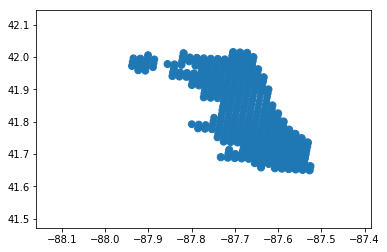

In [4]:
# get shape outside
union=gpd.GeoSeries(unary_union(chi.geometry))
outsideofunion=pd.DataFrame([list(union[0][2].exterior.xy)[0], list(union[0][2].exterior.xy)[1]])
# routine to mask mask over chicago shapefile
mask=np.ones(zlat.shape,dtype=bool)
mask[:] = False  

for i in range(len(zlat)):
    for j in range(len(zlat[0])):
       pt = Point(zlon[i][j],zlat[i][j])
       mask[i][j] =  pt.within(union[0])

plt.scatter(zlon,zlat,var_crop[0][0]*mask)
plt.show()

In [9]:
var_crop_mask = var_crop
var_crop_nm_mask = var_crop_no_mun
var_crop_nb_mask = var_crop_no_bus
var_crop_ns_mask = var_crop_no_school

for i in range(len(var)):
    for j in range(len(var_crop_mask[0])):
        var_crop_mask[i][j][~mask] = np.nan

for i in range(len(var)):
    for j in range(len(var_crop[0])):
        var_crop_nm_mask[i][j][~mask] = np.nan
        
for i in range(len(var)):
    for j in range(len(var_crop[0])):
        var_crop_nb_mask[i][j][~mask] = np.nan

for i in range(len(var)):
    for j in range(len(var_crop[0])):
        var_crop_ns_mask[i][j][~mask] = np.nan

## Monthly Averages

In [5]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
tmp_o3 = []
tmp_no2 = []
tmp_pm = []
for day in days:
    for hr in hours:
        tmp_o3.append([var_crop[0][day*24+hours[hr]]])

monthly_av_o3=np.average(tmp_o3,axis=0)

    
for day in days:
    for hr in hours:
        tmp_no2.append([var_crop[1][day*24+hours[hr]]])
        
monthly_av_no2=np.average(tmp_no2,axis=0)

        
for day in days:
    for hr in hours:
        tmp_pm.append([var_crop[2][day*24+hours[hr]]])

monthly_av_pm=np.average(tmp_pm,axis=0)

In [6]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
tmp_o3_nm = []
tmp_no2_nm = []
tmp_pm_nm = []
for day in days:
    for hr in hours:
        tmp_o3_nm.append([var_crop_no_mun[0][day*24+hours[hr]]])

monthly_av_o3_nm=np.average(tmp_o3_nm,axis=0)
    
for day in days:
    for hr in hours:
        tmp_no2_nm.append([var_crop_no_mun[1][day*24+hours[hr]]])
        
monthly_av_no2_nm=np.average(tmp_no2_nm,axis=0)

        
for day in days:
    for hr in hours:
        tmp_pm_nm.append([var_crop_no_mun[2][day*24+hours[hr]]])

monthly_av_pm_nm=np.average(tmp_pm_nm,axis=0)

In [7]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
tmp_o3_nb = []
tmp_no2_nb = []
tmp_pm_nb = []
for day in days:
    for hr in hours:
        tmp_o3_nb.append([var_crop_no_bus[0][day*24+hours[hr]]])

monthly_av_o3_nb=np.average(tmp_o3_nm,axis=0)
    
for day in days:
    for hr in hours:
        tmp_no2_nb.append([var_crop_no_bus[1][day*24+hours[hr]]])
        
monthly_av_no2_nb=np.average(tmp_no2_nb,axis=0)

        
for day in days:
    for hr in hours:
        tmp_pm_nb.append([var_crop_no_bus[2][day*24+hours[hr]]])

monthly_av_pm_nb=np.average(tmp_pm_nb,axis=0)

In [8]:
monthly_av_o3 =  pd.DataFrame(monthly_av_o3[0])
monthly_av_o3_nm =  pd.DataFrame(monthly_av_o3_nm[0])
monthly_av_no2 =  pd.DataFrame(monthly_av_no2[0])
monthly_av_no2_nm =  pd.DataFrame(monthly_av_no2_nm[0])
monthly_av_pm =  pd.DataFrame(monthly_av_pm[0])
monthly_av_pm_nm =  pd.DataFrame(monthly_av_pm_nm[0])

In [9]:
o3_dif =  monthly_av_o3_nm - monthly_av_o3
no2_dif = monthly_av_no2_nm - monthly_av_no2  
pm_dif = monthly_av_pm_nm - monthly_av_pm  

## Scenario Averages

In [15]:
#NO MUNICIPAL SCENARIO
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
mask_o3_nm = []
mask_no2_nm = []
mask_pm_nm = []
for day in days:
    for hr in hours:
        mask_o3_nm.append([var_crop_nm_mask[0][day*24+hours[hr]]])

mask_av_o3_nm=np.average(mask_o3_nm,axis=0)
    
for day in days:
    for hr in hours:
        mask_no2_nm.append([var_crop_nm_mask[1][day*24+hours[hr]]])
        
mask_av_no2_nm=np.average(mask_no2_nm,axis=0)

        
for day in days:
    for hr in hours:
        mask_pm_nm.append([var_crop_nm_mask[2][day*24+hours[hr]]])

mask_av_pm_nm=np.average(mask_pm_nm,axis=0)

In [16]:
# NO BUS SCENARIO
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
mask_o3_nb = []
mask_no2_nb = []
mask_pm_nb = []
for day in days:
    for hr in hours:
        mask_o3_nb.append([var_crop_nb_mask[0][day*24+hours[hr]]])

mask_av_o3_nb=np.average(mask_o3_nb,axis=0)
    
for day in days:
    for hr in hours:
        mask_no2_nb.append([var_crop_nb_mask[1][day*24+hours[hr]]])
        
mask_av_no2_nb=np.average(mask_no2_nb,axis=0)

        
for day in days:
    for hr in hours:
        mask_pm_nb.append([var_crop_nb_mask[2][day*24+hours[hr]]])

mask_av_pm_nb=np.average(mask_pm_nb,axis=0)

In [17]:
# NO SCHOOL SCENARIO
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
mask_o3_ns = []
mask_no2_ns = []
mask_pm_ns = []
for day in days:
    for hr in hours:
        mask_o3_ns.append([var_crop_ns_mask[0][day*24+hours[hr]]])

mask_av_o3_ns=np.average(mask_o3_ns,axis=0)
    
for day in days:
    for hr in hours:
        mask_no2_ns.append([var_crop_ns_mask[1][day*24+hours[hr]]])
        
mask_av_no2_ns=np.average(mask_no2_ns,axis=0)

        
for day in days:
    for hr in hours:
        mask_pm_ns.append([var_crop_ns_mask[2][day*24+hours[hr]]])

mask_av_pm_ns=np.average(mask_pm_ns,axis=0)

In [18]:
# BASE CASE
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
days = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
mask_o3 = []
mask_no2 = []
mask_pm = []
for day in days:
    for hr in hours:
        mask_o3.append([var_crop_mask[0][day*24+hours[hr]]])

mask_av_o3=np.average(mask_o3,axis=0)
    
for day in days:
    for hr in hours:
        mask_no2.append([var_crop_mask[1][day*24+hours[hr]]])
        
mask_av_no2=np.average(mask_no2,axis=0)

        
for day in days:
    for hr in hours:
        mask_pm.append([var_crop_mask[2][day*24+hours[hr]]])

mask_av_pm=np.average(mask_pm,axis=0)

In [19]:
mask_av_o3 =  np.nanmean(mask_av_o3)
mask_av_o3_nm =  np.nanmean(mask_av_o3_nm)
mask_av_o3_nb =  np.nanmean(mask_av_o3_nb)
mask_av_o3_ns =  np.nanmean(mask_av_o3_ns)
mask_av_no2 =  np.nanmean(mask_av_no2)
mask_av_no2_nm =  np.nanmean(mask_av_no2_nm)
mask_av_no2_nb =  np.nanmean(mask_av_no2_nb)
mask_av_no2_ns =  np.nanmean(mask_av_no2_ns)
mask_av_pm =  np.nanmean(mask_av_pm)
mask_av_pm_nm =  np.nanmean(mask_av_pm_nm)
mask_av_pm_nb =  np.nanmean(mask_av_pm_nb)
mask_av_pm_ns =  np.nanmean(mask_av_pm_ns)

In [20]:
o3_dif_nm =  mask_av_o3_nm - mask_av_o3
no2_dif_nm = mask_av_no2_nm - mask_av_no2  
pm_dif_nm = mask_av_pm_nm - mask_av_pm  

o3_dif_nb =  mask_av_o3_nb - mask_av_o3
no2_dif_nb = mask_av_no2_nb - mask_av_no2  
pm_dif_nb = mask_av_pm_nb - mask_av_pm  

o3_dif_ns =  mask_av_o3_ns - mask_av_o3
no2_dif_ns = mask_av_no2_ns - mask_av_no2  
pm_dif_ns = mask_av_pm_ns - mask_av_pm  

In [39]:
# NO MUNICIPAL DIFERENCES
o3_dif_nm, no2_dif_nm, pm_dif_nm

(0.12042246937432566, -0.12674286490952724, -0.014083805102385938)

In [40]:
# NO BUS DIFERENCES
o3_dif_nb, no2_dif_nb, pm_dif_nb

(0.041107840169331666, -0.06440781454906386, 0.015137827388475245)

In [41]:
# NO SCHOOL DIFERENCES
o3_dif_ns, no2_dif_ns, pm_dif_ns

(0.12042246937432566, -0.12674286490952724, -0.014083805102385938)

In [21]:
# O3 Differences
o3_dif_nm, o3_dif_nb, o3_dif_ns

(0.2390899312378707, 0.041107840169331666, 0.12042246937432566)

In [22]:
# NO2 Differences 
no2_dif_nm, no2_dif_nb, no2_dif_ns

(-0.2427546080354137, -0.06440781454906386, -0.12674286490952724)

In [24]:
# PM2.5 Differences
pm_dif_nm, pm_dif_nb, pm_dif_ns

(-0.027238646576901004, 0.015137827388475245, -0.014083805102385938)

## Plotting

In [10]:
# Plot projection
crs_new = ccrs. AlbersEqualArea(central_longitude=(chi.bounds.mean().minx+chi.bounds.mean().maxx)/2)

In [20]:
# Calculate levels for plotting 
monthly_avs = [monthly_av_o3, monthly_av_no2, monthly_av_pm]
maxs = []
mins = []
for i in range(len(monthly_avs)):
    maxs.append(monthly_avs[i].max().max())
    mins.append(monthly_avs[i].min().min())

no2_level = np.arange(9, 34, 1.5)
o3_level = np.arange(25, 47 ,1.5)
pm_level = np.arange(8, 15.5, .5)

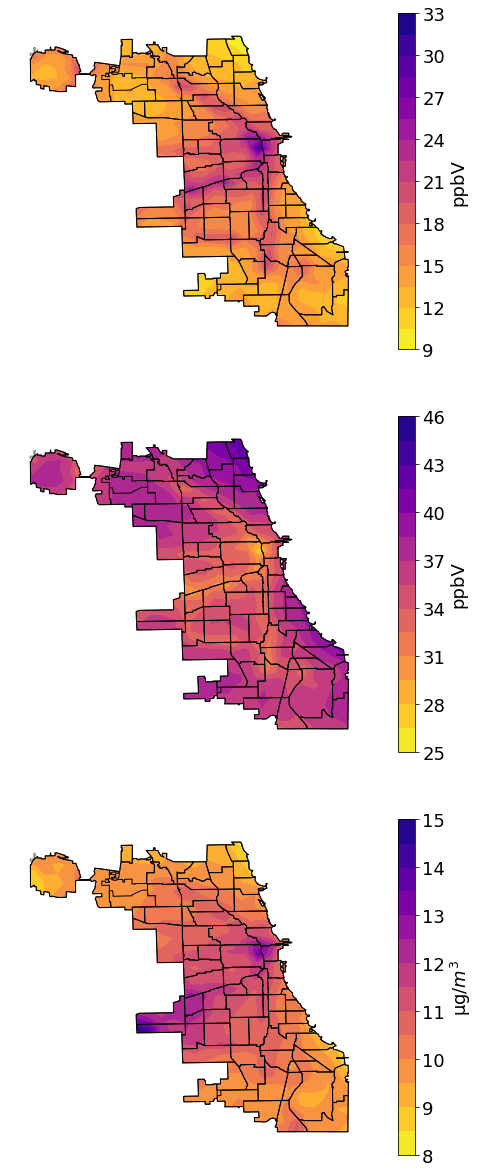

In [21]:
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

# make fig object
%matplotlib inline

fig, (axs1, axs2, axs3) = plt.subplots(3,1,subplot_kw={'projection': crs_new},figsize=(12, 21))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,monthly_av_no2, transform=crs_new, levels=no2_level, cmap = "plasma_r")
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


# OZONE PLOT
chi.plot(ax=axs2, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,monthly_av_o3, transform=crs_new, levels=o3_level, cmap = "plasma_r")
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


# NO2 PLOT
chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon,zlat,monthly_av_pm, transform=crs_new, levels=pm_level, cmap = "plasma_r")
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)

#add colorbar and label
cbar1 = plt.colorbar(cs1, ax = axs1,fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 
cbar2 = plt.colorbar(cs2, ax = axs2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 
cbar3 = plt.colorbar(cs3, ax = axs3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 
cbar1.ax.set_ylabel('ppbV', size = 18)
cbar2.ax.set_ylabel('ppbV', size = 18)
cbar3.ax.set_ylabel(u"\u03bcg/$m^3$", size = 18)


#cbar1.set_ticks(np.arange(mins[1], maxs[1], 10))


fig.savefig("/home/alr4786/base_monthly_av.pdf")

In [22]:
# Calculate levels for plotting 
difs = [o3_dif, no2_dif, pm_dif]
dif_maxs = []
dif_mins = []
for i in range(len(difs)):
    dif_maxs.append(difs[i].max().max())
    dif_mins.append(difs[i].min().min())
    
no2_dif_lev = np.arange(-.6,0.6, 0.075)
o3_dif_lev = np.arange(-0.6, 0.6, 0.075)
pm_dif_lev = np.arange(-.2, 0.2, 0.025)

In [23]:
cmap1 = center_cmap(plt.cm.RdBu_r, -.6,0.6)
cmap2 = center_cmap(plt.cm.RdBu_r, -0.6, 0.6)
cmap3 = center_cmap(plt.cm.RdBu_r, -.2, 0.2)

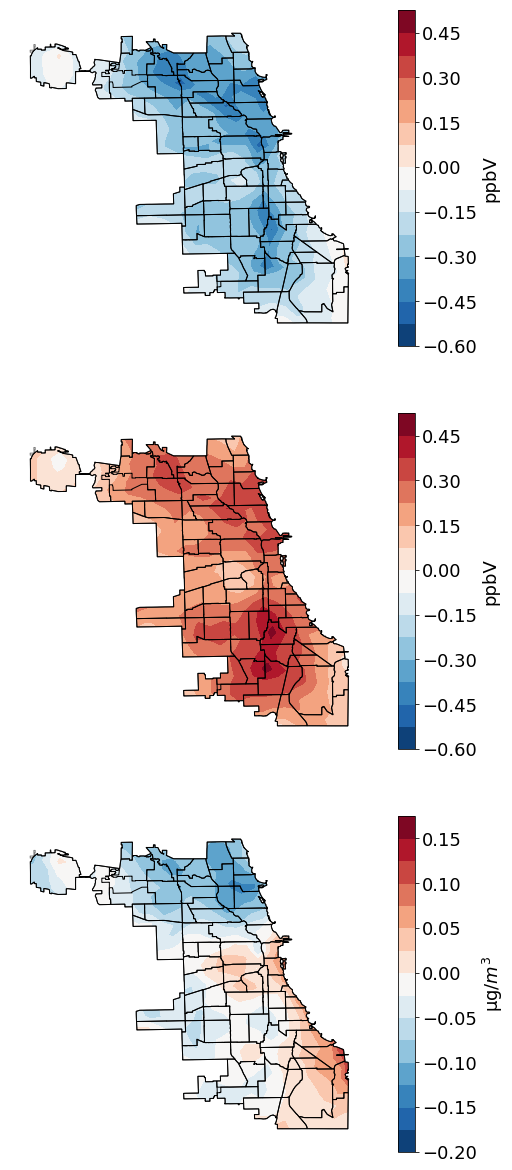

In [25]:
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

# make fig object
%matplotlib inline

fig, (axs1, axs2, axs3) = plt.subplots(3,1,subplot_kw={'projection': crs_new},figsize=(12, 21))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,no2_dif, transform=crs_new, levels=no2_dif_lev, cmap = cmap1)
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs2, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,o3_dif, transform=crs_new, levels=o3_dif_lev, cmap = cmap2)
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon, zlat,pm_dif, transform=crs_new, levels=pm_dif_lev, cmap = cmap3)
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


#add colorbar and label
cbar1 = plt.colorbar(cs1, ax = axs1,fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 
cbar2 = plt.colorbar(cs2, ax = axs2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 
cbar3 = plt.colorbar(cs3, ax = axs3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 
cbar1.ax.set_ylabel('ppbV', size = 18)
cbar2.ax.set_ylabel('ppbV', size = 18)
cbar3.ax.set_ylabel(u"\u03bcg/$m^3$", size = 18)


fig.savefig("/home/alr4786/monthly_av_dif.pdf")